In [115]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy.special import ellipe
from torch.fft import fft2, fftshift, ifft2, ifftn, ifftshift

In [116]:
R = 9.8e-3 # Radius to center [m].
v0, v1 = 1511.4, 1553.0 # Background SoS & SoS in tissue [m/s].

In [117]:
N, l = 80, 3.2e-3
def get_fourier_coord(n_points=80, l=3.2e-3, device='cuda:0'):
	fx1D = torch.linspace(-np.pi/l, np.pi/l, n_points, requires_grad=False, device=device)
	fy1D = torch.linspace(-np.pi/l, np.pi/l, n_points, requires_grad=False, device=device)
	[fx2D, fy2D] = torch.meshgrid(fx1D, fy1D, indexing='xy')
	k2D = torch.sqrt(fx2D**2 + fy2D**2) * n_points
	theta2D = torch.arctan2(fy2D, fx2D) + np.pi/2 # Add `np.pi/2` to match the polar definition of the theta.
	return k2D, theta2D % (2*np.pi)
k2D, theta2D = get_fourier_coord(N, l, 'cpu')
theta1D = torch.linspace(0, 2*np.pi, N)

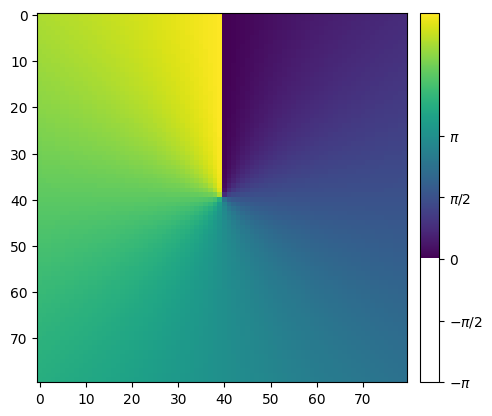

In [118]:
fig = plt.figure()
ax = plt.subplot(1,1,1)
plt.imshow(theta2D)
cax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0, 0.03, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cb.ax.set_yticklabels(['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
cb.ax.tick_params(labelsize=10)

In [119]:
def get_fourier_params(r, phi, R, v0, v1):
    C0 = (1-v0/v1) * R * (1 - (r**2)/(4*R**2))
    C1 = (1-v0/v1) * r 
    C2 = (1-v0/v1) * r**2 / (4*R)
    phi1, phi2 = phi, phi
    return C0, C1, phi1, C2, phi2

def wavefront_fourier(C0, C1, phi1, C2, phi2):
    return lambda theta: C0 + C1 * torch.cos(theta - phi1) + C2 * torch.cos(2 * (theta - phi2))

def wavefront_real(R, r, phi, v0, v1):
    if r < R:
        return lambda theta: (1-v0/v1) * (torch.sqrt(R**2 - (r*torch.sin(theta-phi))**2) + r * torch.cos(theta-phi))
    else:
        return lambda theta: (1-v0/v1) * 2 * torch.sqrt(torch.maximum(R**2 - (r*torch.sin(theta-phi))**2, torch.zeros_like(theta))) * (torch.cos(phi-theta) >= 0)

def PSF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) * (theta >= 0) * (theta <= np.pi) + torch.exp(1j*k*(delay - w(theta+np.pi)))* (theta >= np.pi) * (theta <= 2*np.pi)) / 2
    tf 
    psf = fftshift(ifft2(ifftshift(tf, dim=[-2,-1])), dim=[-2,-1]).abs()
    psf /= psf.sum(axis=(-2,-1)) # Normalization.
    return psf 

def TF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) + torch.exp(1j*k*(delay - w(theta+np.pi)))) / 2
    return tf

### $r =< R$

0.0002071608604807019 0.00024108177720540843 5.5350408031853975e-05


(0.0, 6.283185307179586)

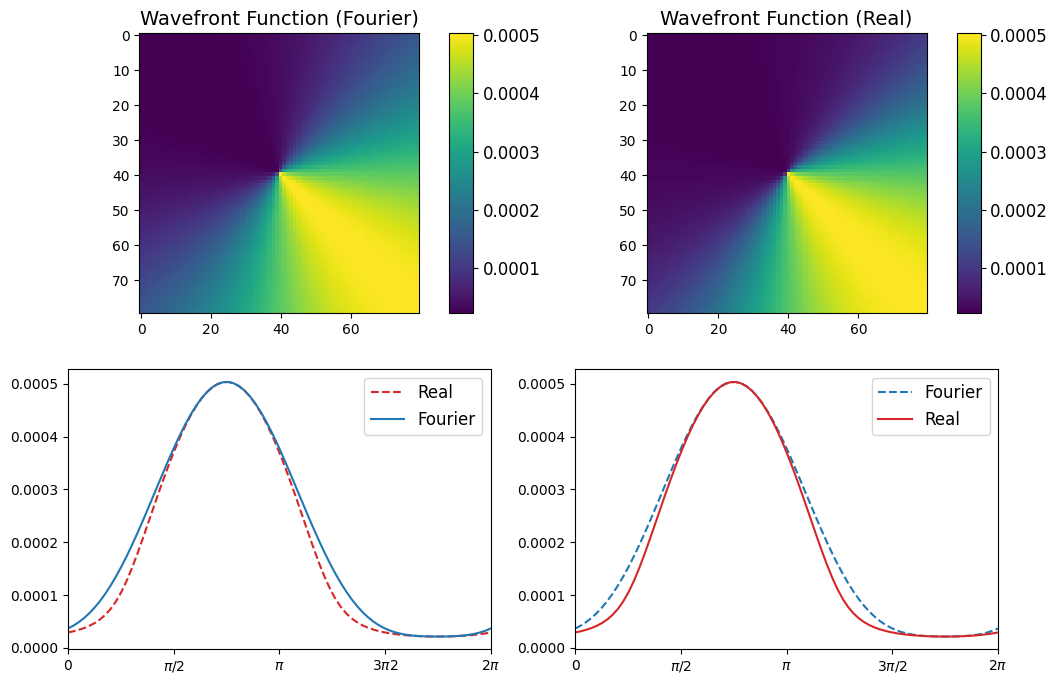

In [120]:
r = 9e-3 # Distance to center [m].
phi = 3*np.pi/4 # Angle to center [rad].
C0, C1, phi1, C2, phi2 = get_fourier_params(r, phi, R, v0, v1)
print(C0, C1, C2)
w_fourier = wavefront_fourier(C0, C1, phi, C2, phi)
w_real = wavefront_real(R, r, phi, v0, v1)

# Visualizations.
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(2,2,1)
plt.imshow(w_fourier(theta2D))
ax1.set_title('Wavefront Function (Fourier)', fontsize=14)
cax = fig.add_axes([ax1.get_position().x1+0.025, ax1.get_position().y0, 0.02, ax1.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.tick_params(labelsize=12)

ax3 = plt.subplot(2,2,3)
plt.plot(theta1D, w_real(theta1D), color='tab:red', label='Real', linestyle='--')
plt.plot(theta1D, w_fourier(theta1D), color='tab:blue', label='Fourier')
ax3.legend(fontsize=12)
ax3.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax3.set_xticklabels(['0','$\pi$/2','$\pi$','$3\pi$2','2$\pi$'])
ax3.set_xlim(0, 2*np.pi)

ax2 = plt.subplot(2,2,2)
plt.imshow(w_real(theta2D))
ax2.set_title('Wavefront Function (Real)', fontsize=14)
cax = fig.add_axes([ax2.get_position().x1+0.025, ax2.get_position().y0, 0.02, ax2.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.tick_params(labelsize=12)

ax4 = plt.subplot(2,2,4)
plt.plot(theta1D, w_fourier(theta1D), color='tab:blue', label='Fourier', linestyle='--')
plt.plot(theta1D, w_real(theta1D), color='tab:red', label='Real')
ax4.legend(fontsize=12)
ax4.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax4.set_xticklabels(['0','$\pi$/2','$\pi$','$3\pi$/2','2$\pi$'])
ax4.set_xlim(0,2*np.pi)

# plt.savefig('../figures/wavefront.jpg', bbox_inches='tight')

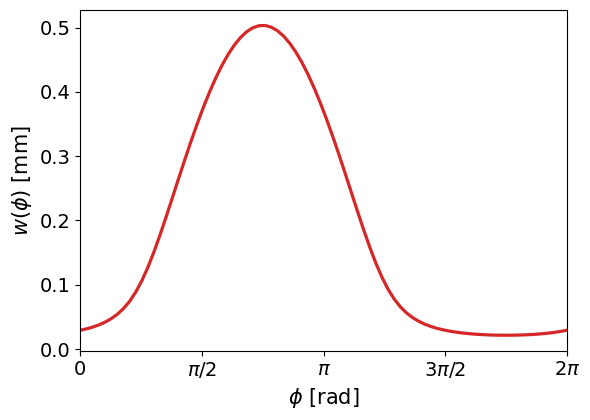

In [121]:
plt.figure(figsize=(6,4.3))
plt.plot(theta1D, w_real(theta1D)*1e3, color='tab:red', linewidth=2.3)
ax = plt.gca()
ax.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax.set_xticklabels(['0','$\pi$/2','$\pi$','$3\pi$/2','2$\pi$'])
ax.set_xlim(0, 2*np.pi)
plt.tick_params(labelsize=14)
plt.xlabel('$\phi$ [rad]', fontsize=15)
plt.ylabel('$w(\phi)$ [mm]', fontsize=15)
# plt.yticks([])
plt.tight_layout()

In [122]:
def get_delays(R, v0, v1, n_delays, mode='linear'):
    if mode == 'linear':
        return np.linspace(0, (1-v0/v1) * R, n_delays)
    elif mode == 'quadric':
        return (1-v0/v1) * R * np.sqrt(np.linspace(0,1,n_delays))
    else:
        raise NotImplementedError
    
n_delays = 8
# delays = get_delays(R, v0, v1, n_delays, 'linear')
delays = np.linspace(-8e-4, 8e-4, n_delays)
print(delays)

[-0.0008     -0.00057143 -0.00034286 -0.00011429  0.00011429  0.00034286
  0.00057143  0.0008    ]


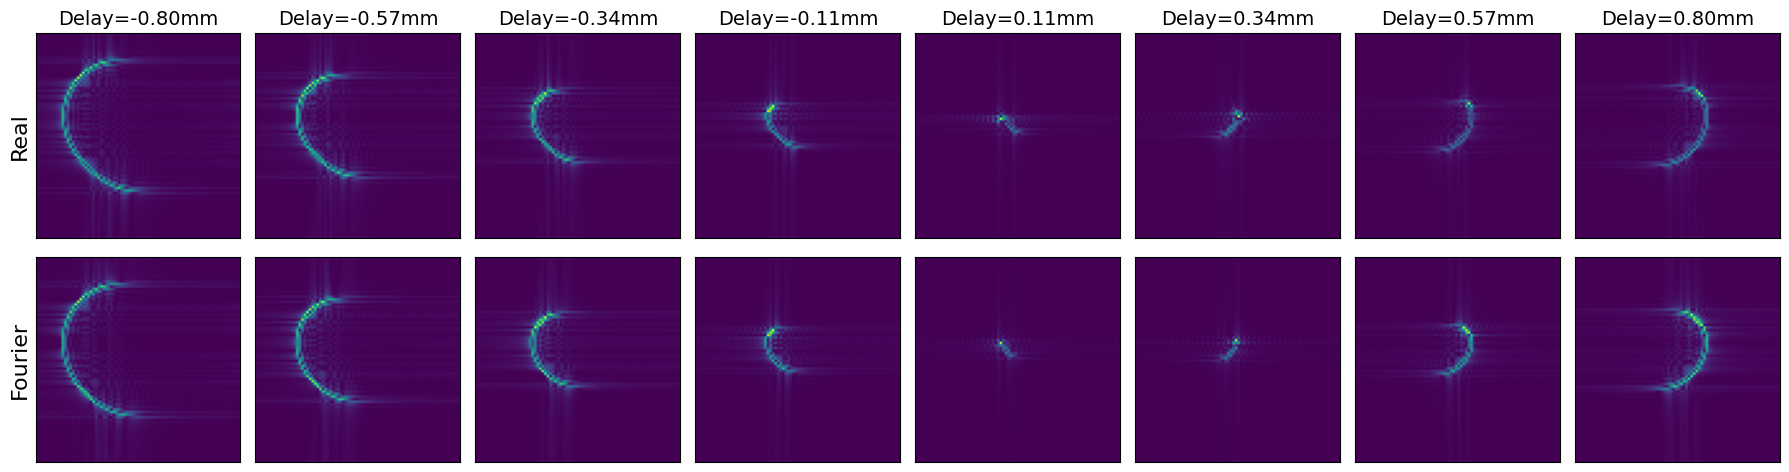

In [123]:
fig = plt.figure(figsize=(18, 5))
for i, (w, label) in enumerate(zip([w_real, w_fourier], ['Real', 'Fourier'])):
    psfs = []
    for j, delay in enumerate(delays):
        psfs.append(PSF(theta2D, k2D, w, delay))
        plt.subplot(2,8,j+1+8*i)
        plt.imshow(psfs[j])
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.title('Delay={:.2f}mm'.format(delays[j]*1e3), fontsize=14)
        if j == 0:
            plt.ylabel(label, fontsize=16)

plt.tight_layout()
plt.savefig('../figures/psfs.jpg', bbox_inches='tight')

In [124]:
np.save('../data/psfs.npy', np.stack(psfs, axis=0))

### $r > R$

(0.0, 6.283185307179586)

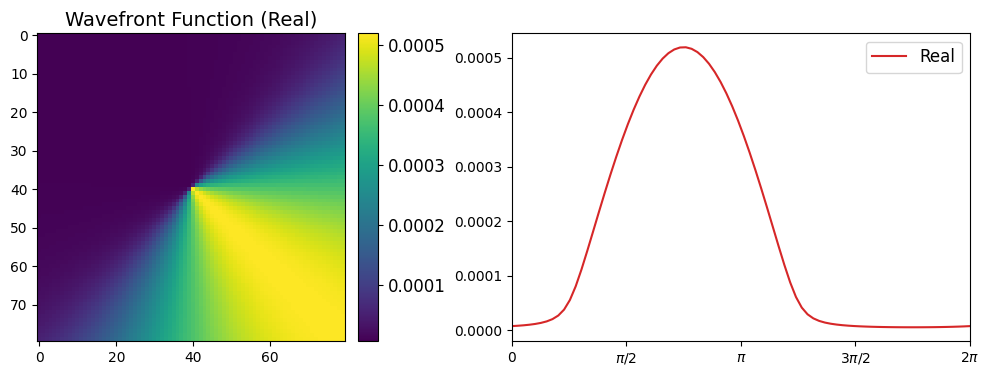

In [125]:
r = 9.6e-3 # Distance to center [m].
phi = 3*np.pi/4 # Angle to center [rad].
w_real = wavefront_real(R, r, phi, v0, v1)

fig = plt.figure(figsize=(13, 4))

ax2 = plt.subplot(1,2,1)
plt.imshow(w_real(theta2D))
ax2.set_title('Wavefront Function (Real)', fontsize=14)
cax = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.015, ax2.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=10)
plt.tick_params(labelsize=12)

ax4 = plt.subplot(1,2,2)
plt.plot(theta1D, w_real(theta1D), color='tab:red', label='Real')
ax4.legend(fontsize=12)
ax4.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax4.set_xticklabels(['0','$\pi$/2','$\pi$','$3\pi$/2','2$\pi$'])
ax4.set_xlim(0, 2*np.pi)

In [126]:
def condition_number(psf, lam=0.0):
    """Calculate the condition number of a PSF.

    Args:
        psf (`numpy.ndarray`): Image of the PSF.
        lam (`float`, optional): Regularization paramter in Wiener filter. Defaults to `0.0`.

    Returns:
        `float`: Condition number.
    """
    H = fft2(psf)
    Ht, HtH = torch.conj(H), torch.abs(H) ** 2
    # return Ht.abs().max() / Ht.abs().min()
    return psf.abs().max() / psf.abs().min()

[0.00000000e+00 3.75016098e-05 7.50032196e-05 1.12504829e-04
 1.50006439e-04 1.87508049e-04 2.25009659e-04 2.62511269e-04]


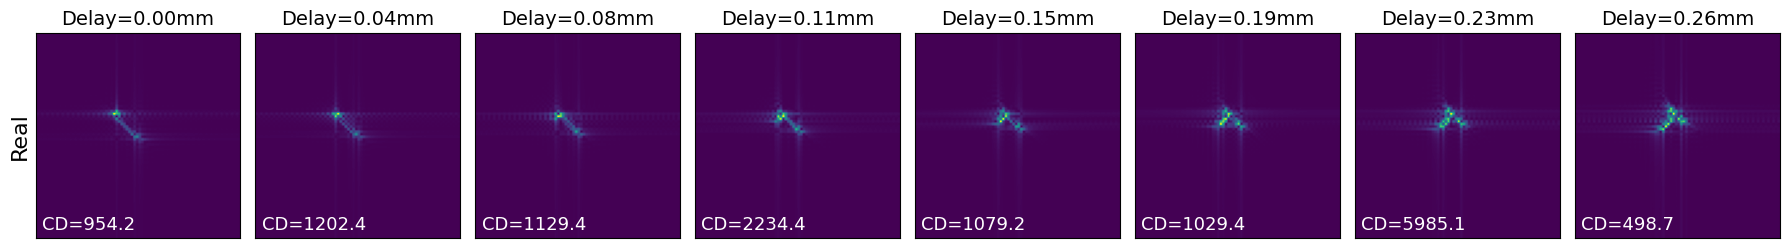

In [127]:
n_delays = 8
delays = get_delays(R, v0, v1, n_delays, 'linear')
print(delays)

fig = plt.figure(figsize=(18, 5))
for i, (w, label) in enumerate(zip([w_real], ['Real'])):
    psfs = []
    for j, delay in enumerate(delays):
        tf = TF(theta2D, k2D, w, delay)
        psfs.append(PSF(theta2D, k2D, w, delay))
        plt.subplot(2,8,j+1)
        plt.imshow(psfs[j])
        plt.xticks([])
        plt.yticks([])
        plt.title('CD={:.1f}'.format(condition_number(tf)), fontsize=13, loc='left', y=0.0, x=0.03, color='white')
        
        if i == 0:
            plt.title('Delay={:.2f}mm'.format(delays[j]*1e3), fontsize=14)
        if j == 0:
            plt.ylabel(label, fontsize=16)
plt.tight_layout()

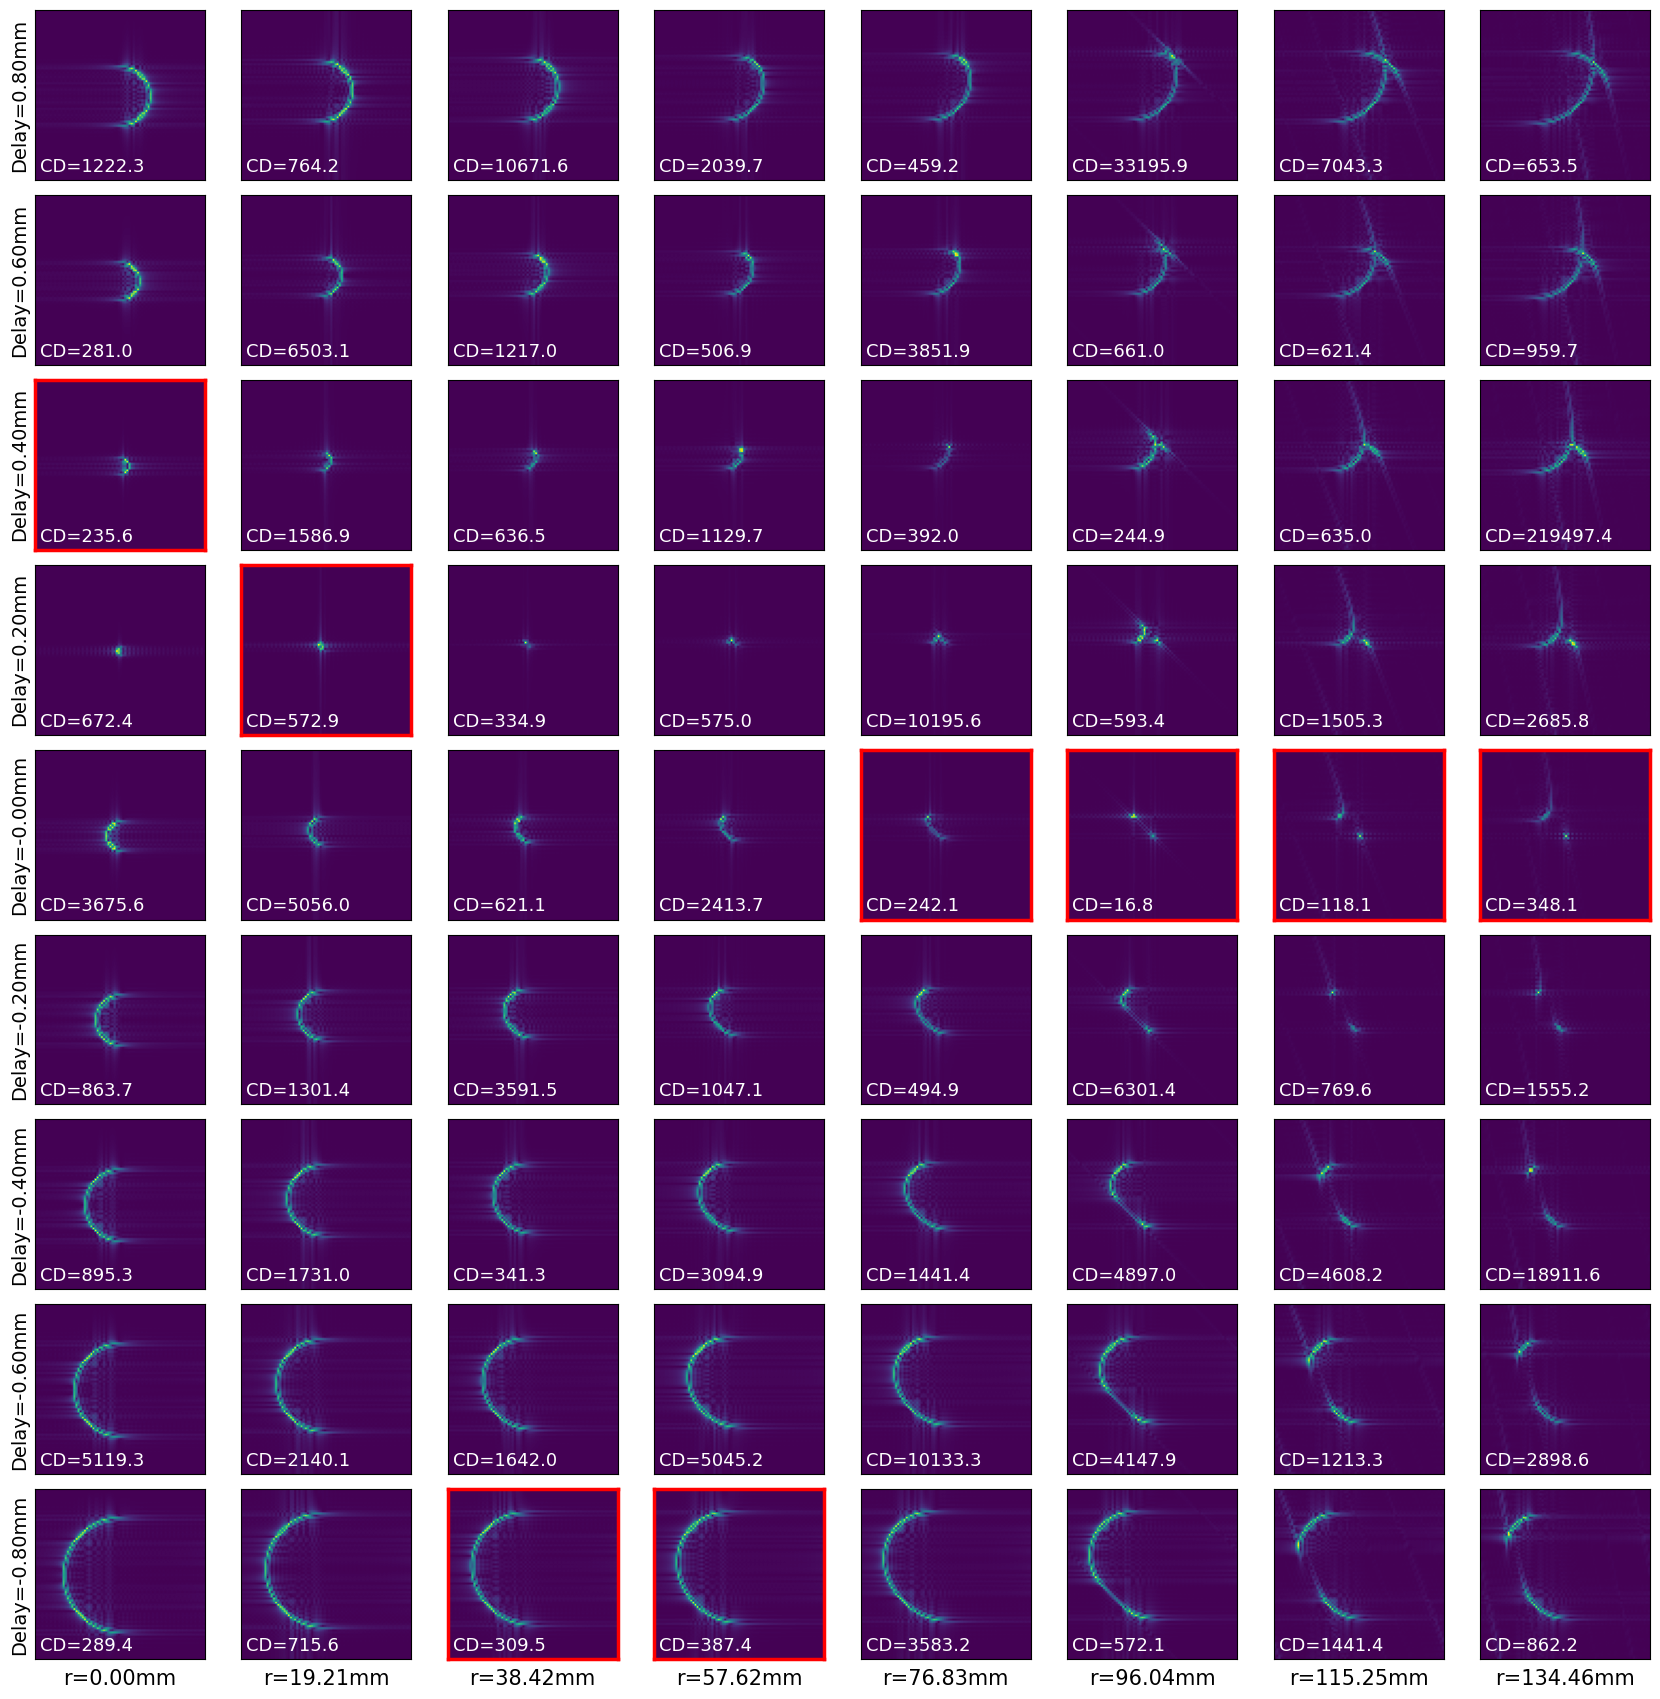

In [128]:
# delays = get_delays(R, v0, v1, n_delays, 'linear')
delays = np.arange(-8e-4, 10e-4, 2e-4)
n_delays = len(delays)
r2s = np.linspace(0, 12, 8)
r2s = R**2 * r2s/r2s[-3]
rs = np.sqrt(r2s)

r2s_draw = np.linspace(0, r2s[-1], 100)
C0s = (1-v0/v1) * R * (1 - r2s_draw/(4*R**2)) * (r2s_draw <= R**2)

fig = plt.figure(figsize=(17, 17))
# ax = fig.add_axes([0, 0, 1, 1])
# ax.set_xlabel('$r^2/mm$', fontsize=17)
# ax.set_ylabel('$d_{Delay}/mm$', fontsize=17)
# ax.plot(r2s_draw, C0s, color='red', linestyle='--')
# ax.set_xlim(0, R**2/r2s[-3]*r2s[-1])
# ax.axis('off')

for i, r in enumerate(rs):
    psfs, tfs = [], []
    w_real = wavefront_real(R, r, phi, v0, v1)
    CD_min = 1e10
    for j, delay in enumerate(delays):
        psfs.append(PSF(theta2D, k2D, w_real, delay))
        tfs.append(TF(theta2D, k2D, w_real, delay))
        cd = condition_number(tfs[j])
        if cd < CD_min:
            CD_min = cd
            CD_min_idx = j
    for j, delay in enumerate(delays):
        ax = plt.subplot(n_delays, len(rs), i+1+len(rs)*(n_delays-j-1))
        plt.imshow(psfs[j])
        plt.xticks([])
        plt.yticks([])
        plt.title('CD={:.1f}'.format(condition_number(tfs[j])), fontsize=13, loc='left', y=0.0, x=0.03, color='white')
        if i == 0:
            plt.ylabel('Delay={:.2f}mm'.format(delays[j]*1e3), fontsize=14)
        if j == 0:
            plt.title('r={:.2f}mm'.format((r*1e3)**2), fontsize=15, y=-0.2)
        if j == CD_min_idx:
            for loc in ['bottom', 'top', 'left', 'right']:
                ax.spines[loc].set_color('red')
                ax.spines[loc].set_linewidth(2.5)
            
plt.tight_layout()

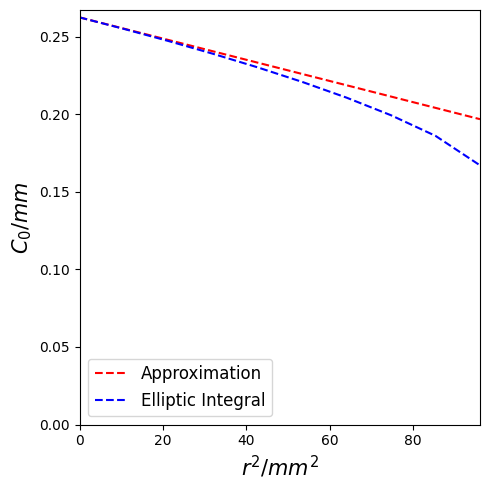

In [129]:
r2s = np.linspace(0, 10, 10)
r2s = R**2 * r2s/r2s[-1]
rs = np.sqrt(r2s)

C0s = (1-v0/v1) * R * (1 - r2s/(4*R**2)) * (r2s <= R**2)
C0_elliptic = 2/np.pi * R * (1-v0/v1) * ellipe(r2s/(R**2))

plt.figure(figsize=(5,5))

plt.plot(r2s*1e6, C0s*1e3, color='red', linestyle='--', label='Approximation')
plt.plot(r2s*1e6, C0_elliptic*1e3, color='blue', linestyle='--', label='Elliptic Integral')
plt.xlim(0, R**2*1e6)
plt.ylim(0, )

plt.xlabel('$r^2/mm^2$', fontsize=15)
plt.ylabel('$C_0/mm$', fontsize=15)
plt.legend(fontsize=12)

plt.tight_layout()

### Fig 3

In [130]:
import sys
sys.path.append('../')
from kwave.ktransducer import kWaveGrid

Nx, Ny = 560, 560
dx, dy = 4.e-5, 4.e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())

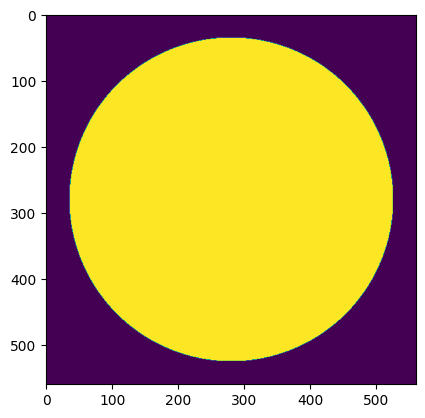

In [131]:
SoS_uniform = np.ones((Ny, Nx)) * v0
SoS_SB = np.ones((Ny, Nx)) * v0
SoS_SB[x_vec**2 + y_vec**2 < R**2] = v1

plt.imshow(SoS_SB)

In [132]:
r = 7e-3 # Distance to center [m].
phi = 3*np.pi/4 # Angle to center [rad].
C0, C1, phi1, C2, phi2 = get_fourier_params(r, phi, R, v0, v1)
print(C0, C1, C2)
w_fourier = wavefront_fourier(C0, C1, phi, C2, phi)
w_real = wavefront_real(R, r, phi, v0, v1)

0.00022902768834513802 0.00018750804893753991 3.348358016741785e-05


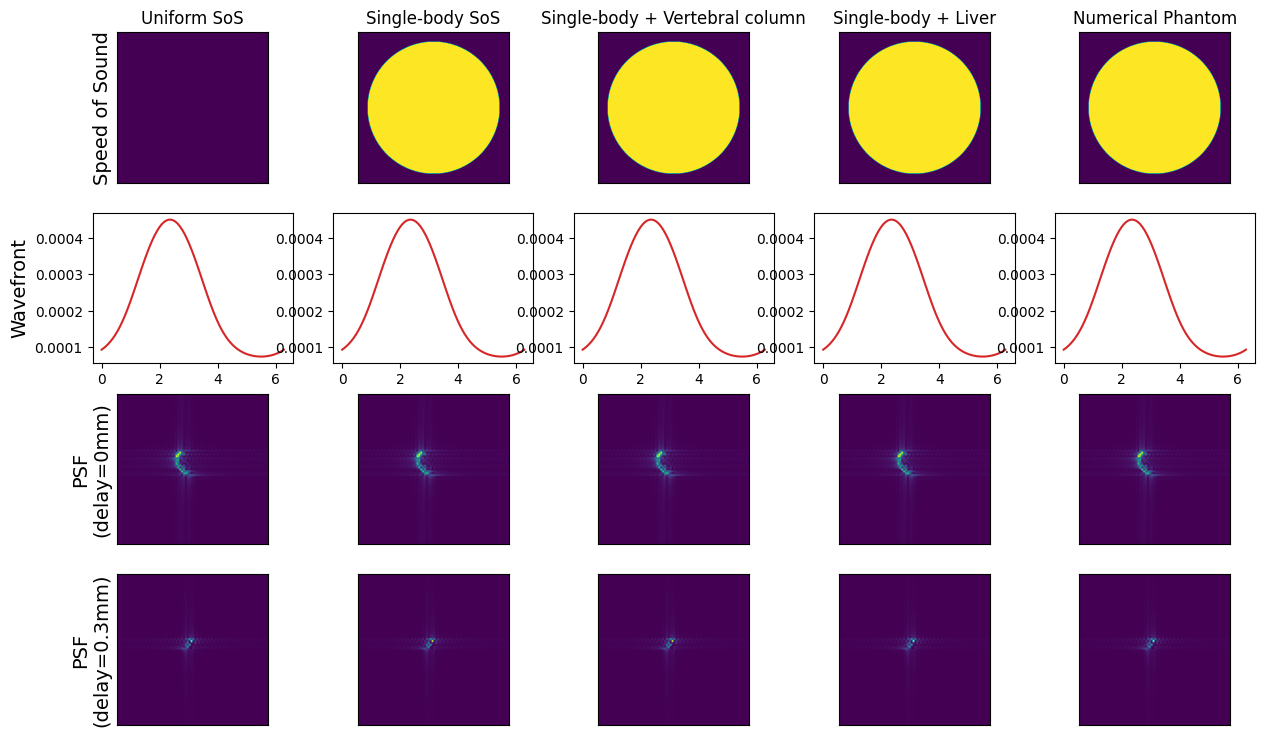

In [133]:
plt.figure(figsize=(15,9))
for i, SoS in enumerate([SoS_uniform, SoS_SB, SoS_SB, SoS_SB, SoS_SB]):
    w_real = wavefront_real(R, r, phi, v0, v1)
    
    plt.subplot(4, 5, i+1)
    plt.imshow(SoS)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Speed of Sound', fontsize=14)
        plt.title('Uniform SoS')
    elif i == 1:
        plt.title('Single-body SoS')
    elif i == 2:
        plt.title('Single-body + Vertebral column')
    elif i == 3:
        plt.title('Single-body + Liver')
    elif i == 4:
        plt.title('Numerical Phantom')
    
    plt.subplot(4, 5, i+6)
    plt.plot(theta1D, w_real(theta1D), color='tab:red', label='Real')
    if i == 0:
        plt.ylabel('Wavefront', fontsize=14)

    plt.subplot(4, 5, i+11)
    plt.imshow(PSF(theta2D, k2D, w_real, 0))
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('PSF\n(delay=0mm)', fontsize=14)
    
    plt.subplot(4, 5, i+16)
    plt.imshow(PSF(theta2D, k2D, w_real, 3e-4))
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('PSF\n(delay=0.3mm)', fontsize=14)